In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

pd.set_option('display.max_rows', 50)
%matplotlib inline

## Load rating data

In [2]:
path = 'data/ml-10M100K/'  # ML-10M files
all_files = glob.glob(os.path.join(path, "ratings*.csv"))
ratings = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

### Get number of ratings per movie

In [3]:
rating_counts = ratings.groupby('movieId').agg({'rating':'count'}).reset_index()
rating_counts.columns = ['movieId', 'n_ratings']
rating_counts.head()

,movieId,n_ratings
0,0,2412
1,1,14975
2,2,17851
3,3,16075
4,4,18925


### Get average rating per movie

In [4]:
rating_avgs = ratings.groupby('movieId').agg({'rating':'mean'}).reset_index()
rating_avgs.columns = ['movieId', 'mean_rating']
rating_avgs.head()

,movieId,mean_rating
0,0,2.861318
1,1,3.125209
2,2,2.936950
3,3,3.418414
4,4,3.349353


### Join to movies file

In [5]:
movies = pd.read_csv(path+'movies.tsv', sep='\t')
movies = pd.merge(movies, rating_counts, how='inner', on='movieId')
movies = pd.merge(movies, rating_avgs, how='inner', on='movieId')

movies.head(10)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_ratings,mean_rating
1293,1293,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,31126,4.457238
34,34,"Godfather, The (1972)",0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,19814,4.415085
213,213,"Usual Suspects, The (1995)",0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,24037,4.367142
133,133,Schindler's List (1993),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,25777,4.363483
1441,1441,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,3255,4.321966
145,145,Casablanca (1942),0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,12507,4.319741
218,218,Rear Window (1954),0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,8825,4.316544
1474,1474,Seven Samurai (Shichinin no samurai) (1954),1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5751,4.314119
226,226,"Third Man, The (1949)",0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,3265,4.313629
165,165,"Godfather: Part II, The (1974)",0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,13281,4.303215


# Embeddings dimensionality reduction
[Multiple distribution jointplot](https://stackoverflow.com/questions/35920885/how-to-overlay-a-seaborn-jointplot-with-a-marginal-distribution-histogram-fr)

In [6]:
emb = pd.read_csv(path+'embeddings.csv')
emb.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,e190,e191,e192,e193,e194,e195,e196,e197,e198,e199
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0.087806,0.127755,0.020493,0.033983,-0.116912,-0.012477,-0.045383,0.007603,0.150989,-0.148305
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0.077832,0.008988,0.014570,0.073239,0.124648,-0.134136,-0.114936,0.071621,0.278991,0.044786
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,-0.046292,-0.049686,0.218707,-0.030238,-0.197417,-0.022804,0.056282,-0.186790,-0.039575,-0.325568
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0.010315,0.058355,-0.088681,0.181235,0.037869,0.079277,0.070823,0.164783,0.237280,0.022873
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,-0.065126,0.078158,-0.027330,0.022515,0.092744,0.284196,-0.122310,0.033767,-0.013537,0.319222


## Use PCA, MDS and t-sne to reduce embeddings to 2 dimensions

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold.t_sne import TSNE
from sklearn.manifold.mds import MDS

In [9]:
# compute PCA to get first two components
pca = PCA(n_components=2)
t_sne = TSNE(n_components=2)
mds = MDS(n_components=2, n_jobs=-1)

# add pc1, pc2, mds1, mds2, tsne1, tsne2 to emb dataframe
emb[['pc1', 'pc2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-200:]), columns=['pc1', 'pc2'])
emb[['mds1', 'mds2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-202:-2]), columns=['mds1', 'mds2'])
emb[['tsne1', 'tsne2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-204:-4]), columns=['tsne1', 'tsne2'])

df = pd.merge(movies, emb[['movieId', 'pc1', 'pc2', 'mds1', 'mds2', 'tsne1', 'tsne2']], how='inner', on='movieId')
df.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,e196,e197,e198,e199,pc1,pc2,mds1,mds2,tsne1,tsne2
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,-0.045383,0.007603,0.150989,-0.148305,0.733743,-0.413725,0.733743,-0.413727,0.733743,-0.413727
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,-0.114936,0.071621,0.278991,0.044786,1.060578,-0.808901,1.060578,-0.808902,1.060578,-0.808903
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0.056282,-0.186790,-0.039575,-0.325568,0.368845,0.118455,0.368845,0.118454,0.368845,0.118452
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0.070823,0.164783,0.237280,0.022873,0.752705,-0.836050,0.752705,-0.836049,0.752705,-0.836050
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,-0.122310,0.033767,-0.013537,0.319222,0.550180,-0.561946,0.550180,-0.561946,0.550180,-0.561947


In [12]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (10,10),
            'font.family': 'serif'})

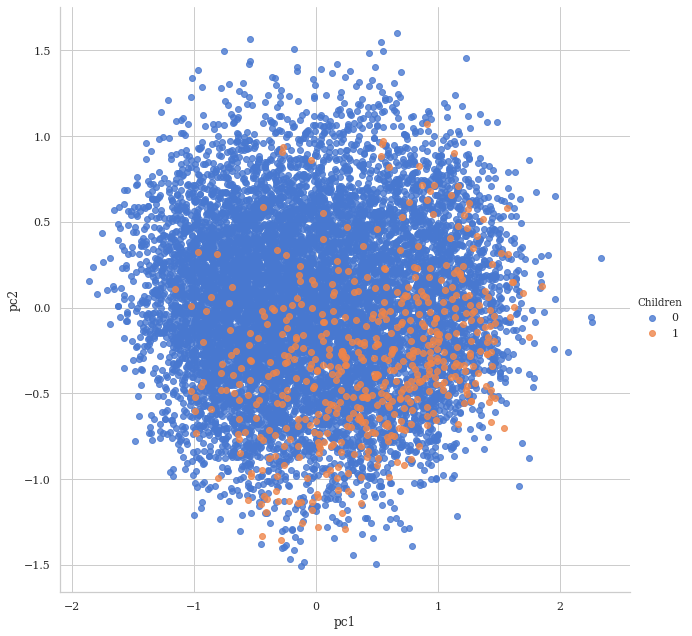

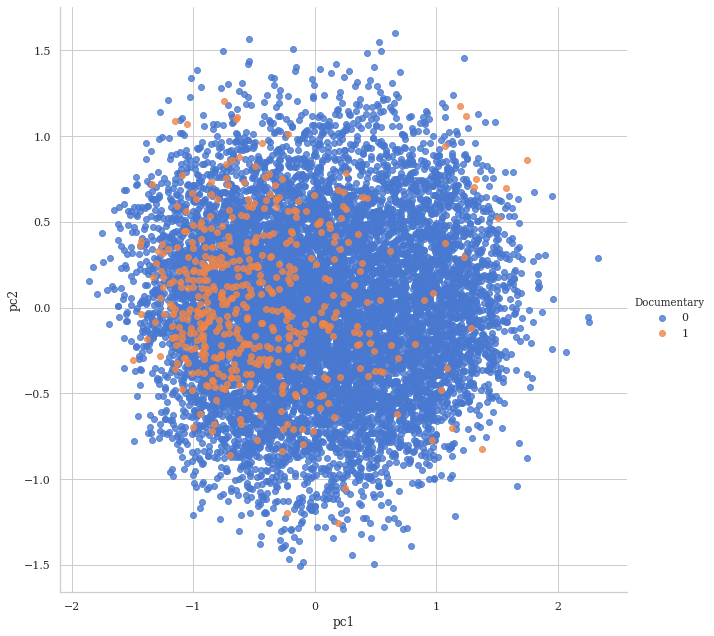

In [25]:
sns.lmplot(x='pc1', y='pc2', data=df, hue='Children', fit_reg=False, height=9)
sns.lmplot(x='pc1', y='pc2', data=df, hue='Documentary', fit_reg=False, height=9)

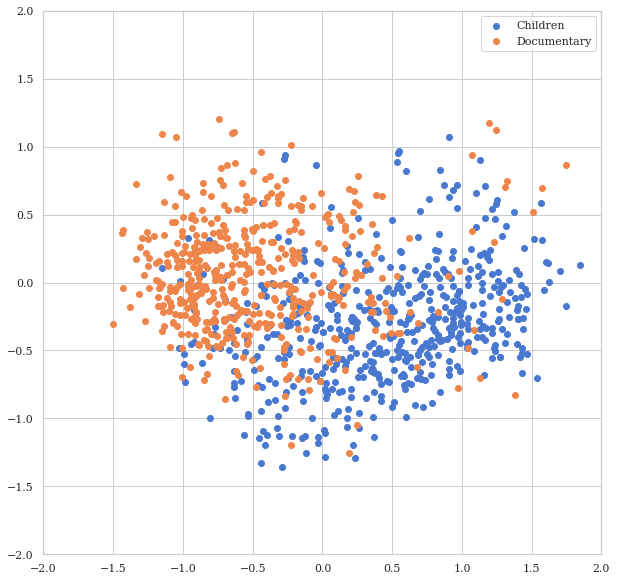

In [41]:
children = (df['Children']==1) & (df['Documentary']==0)
documentary = (df['Children']==0) & (df['Documentary']==1)
plt.scatter(x=df[children].tsne1, y=df[children].tsne2, label='Children')
plt.scatter(x=df[documentary].tsne1, y=df[documentary].tsne2, label='Documentary')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()

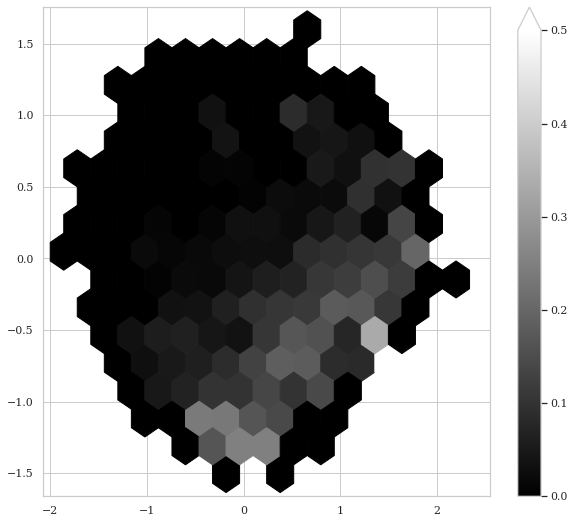

In [42]:
plt.figure(figsize=(10,9))
plt.hexbin(x=df.mds1, y=df.mds2, C=df.Children, gridsize=15, cmap='gist_gray', mincnt=1)
plt.colorbar(spacing='uniform', extend='max')

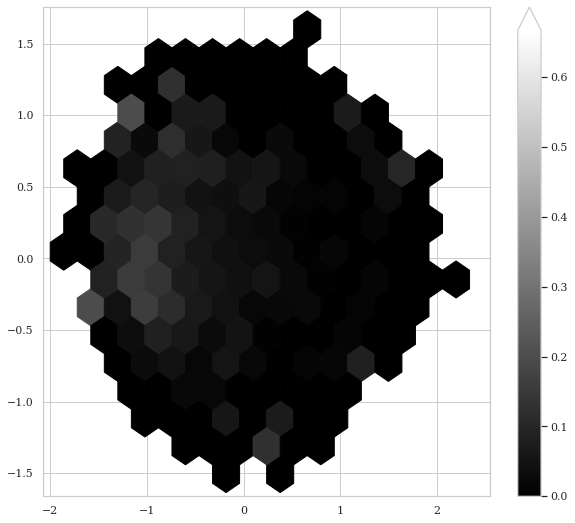

In [43]:
plt.figure(figsize=(10,9))
plt.hexbin(x=df.mds1, y=df.mds2, C=df.Documentary, gridsize=15, cmap='gist_gray', mincnt=1)
plt.colorbar(spacing='uniform', extend='max')

## Plot top 10 rated movies

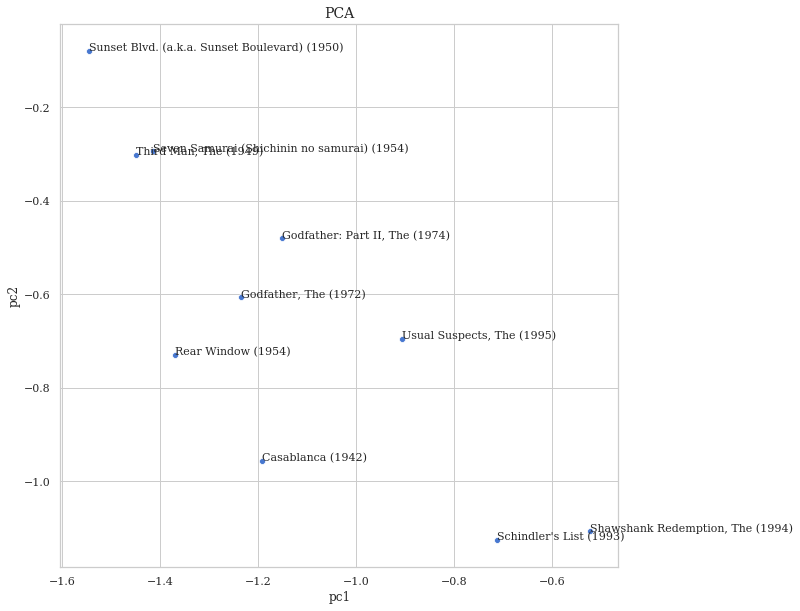

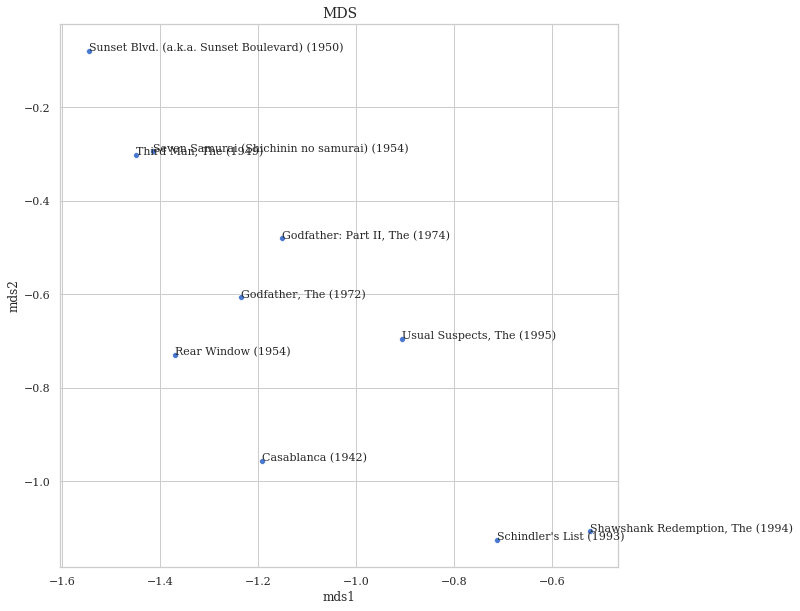

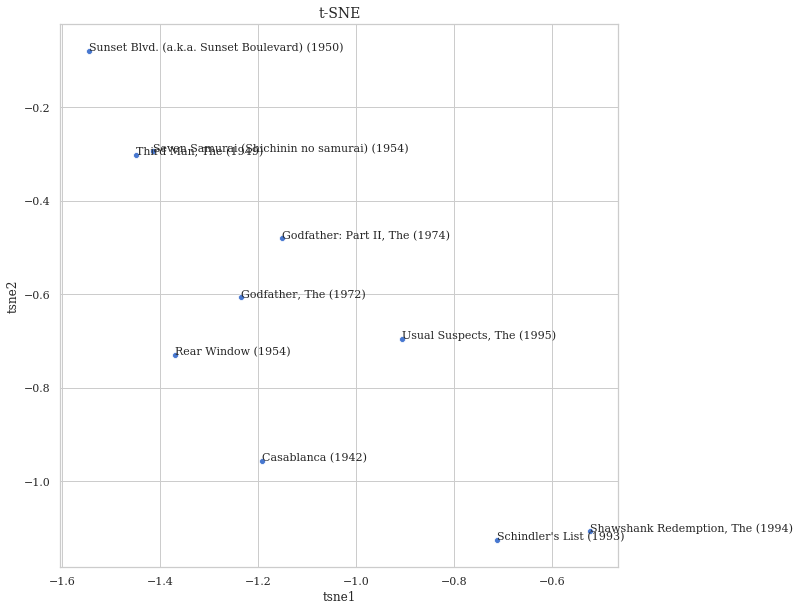

In [44]:
# get top 10 rated movies out of top 1000 most rated
top_10 = df.sort_values('n_ratings').tail(1000).sort_values('mean_rating', ascending=False).head(10)
sns.scatterplot(x='pc1', y='pc2', data=top_10)
plt.title('PCA', fontsize=14)
for idx, row in top_10.iterrows():
    plt.text(row.pc1, row.pc2, row.title, fontsize=11)
plt.show()
    
sns.scatterplot(x='mds1', y='mds2', data=top_10)
plt.title('MDS', fontsize=14)
for idx, row in top_10.iterrows():
    plt.text(row.mds1, row.mds2, row.title, fontsize=11)
plt.show()

sns.scatterplot(x='tsne1', y='tsne2', data=top_10)
plt.title('t-SNE', fontsize=14)
for idx, row in top_10.iterrows():
    plt.text(row.tsne1, row.tsne2, row.title, fontsize=11)
plt.show()

In [45]:
lotr = df[df.title.str.contains('Lord of the Rings') & ~df.title.str.contains('1978')]
hp = df[df.title.str.contains('Harry Potter')]
sw = df[df.title.str.contains('Star Wars')]
gf = df[df.title.str.contains('Godfather, The') | df.title.str.contains('Godfather: Part II')]

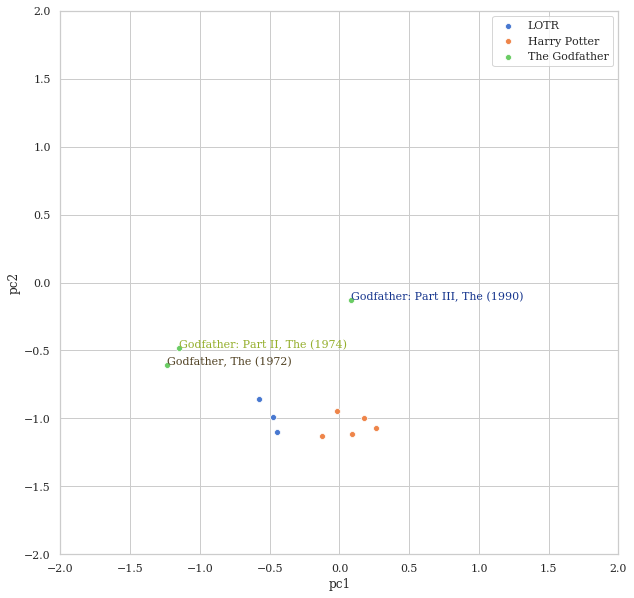

In [46]:
sns.scatterplot(x='pc1', y='pc2', data=lotr, label='LOTR')
sns.scatterplot(x='pc1', y='pc2', data=hp, label='Harry Potter')
# sns.scatterplot(x='pc1', y='pc2', data=sw, label='Star Wars')
sns.scatterplot(x='pc1', y='pc2', data=gf, label='The Godfather')
for idx, row in gf.iterrows():
    plt.text(row.pc1, row.pc2, row.title, color=np.random.rand(3)*0.7, fontsize=11)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()

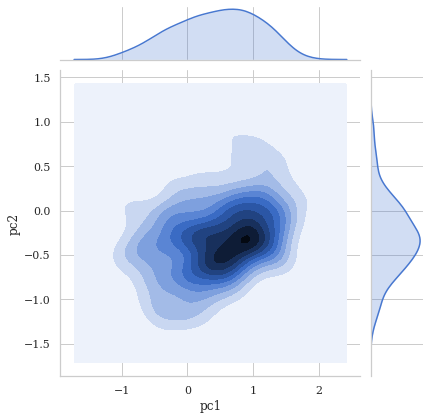

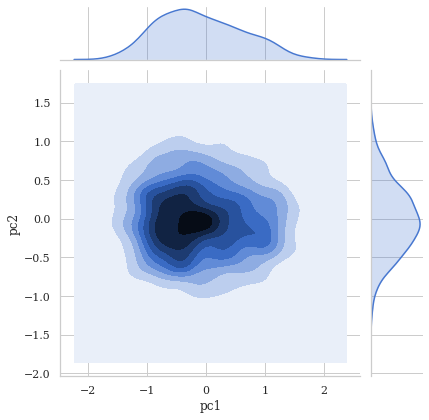

In [50]:
sns.jointplot(x='pc1', y='pc2', data=df[df['Children']==1], kind='kde', label='Children')
sns.jointplot(x='pc1', y='pc2', data=df[df['Crime']==1], kind='kde', label='Crime')